In [1]:
from sklearn.linear_model import LogisticRegression

from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy,
)

from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR,
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 人工データの生成

p.87

生成データフォーマット

- `n_rounds`: データ数
- `n_actions`: 意思決定モデルが選択できる行動の数
- `context`: 各データに対する特徴量
- `action_context`: 行動を表現するone-hotベクトル
- `action`: 過去の意思決定モデル`pi_b`によって選択された行動
- `reward`: 過去の意思決定モデル`pi_b`によって選択された行動に対する報酬
- `expected_reward`: 各行動に対する報酬の期待値。因果推論モデルで最終的に得たい情報
- `pscore`: 過去の意思決定モデル`pi_b`による行動選択確率

In [2]:
dataset = SyntheticBanditDataset(
    n_actions=3,
    dim_context=3,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)

In [3]:
training_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
validation_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)

In [4]:
training_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[-0.20470766,  0.47894334, -0.51943872],
        [-0.5557303 ,  1.96578057,  1.39340583],
        [ 0.09290788,  0.28174615,  0.76902257],
        ...,
        [ 0.42468038,  0.48214752, -0.57647866],
        [-0.51595888, -1.58196174, -1.39237837],
        [-0.74213546, -0.93858948,  0.03919589]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([2, 1, 0, ..., 0, 0, 2]),
 'position': None,
 'reward': array([1, 1, 1, ..., 1, 1, 1]),
 'expected_reward': array([[0.80234945, 0.93064921, 0.89765938],
        [0.97029223, 0.9794874 , 0.87322685],
        [0.68713039, 0.80479091, 0.71774089],
        ...,
        [0.51266281, 0.82015984, 0.82594262],
        [0.60958744, 0.82872573, 0.8975109 ],
        [0.82984387, 0.88413799, 0.85157199]]),
 'pi_b': array([[[0.31046875],
         [0.34759217],
         [0.34193909]],
 
        [[0.27233556],
         [0.36713323],
         [0.36053121]],
 

In [5]:
training_data["action_context"].tolist()

[[1, 0, 0], [0, 1, 0], [0, 0, 1]]

In [6]:
set(training_data["reward"].tolist())

{0, 1}

In [7]:
validation_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[-0.11650276,  2.03041669, -1.69254998],
        [ 1.12507165,  2.79660067,  1.31860865],
        [-1.20648929, -1.67810852, -0.68169251],
        ...,
        [-0.7546995 ,  1.08634882,  1.40322608],
        [ 1.21124369,  1.32085622,  1.80748171],
        [ 0.47636571,  0.91040977, -1.17276984]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([2, 1, 0, ..., 0, 0, 2]),
 'position': None,
 'reward': array([1, 1, 1, ..., 1, 1, 1]),
 'expected_reward': array([[0.90019297, 0.98664076, 0.97140423],
        [0.62116139, 0.84704539, 0.64536846],
        [0.87498072, 0.91970449, 0.91544817],
        ...,
        [0.96345478, 0.96794483, 0.85197901],
        [0.33034248, 0.50660141, 0.38877329],
        [0.54474688, 0.88526753, 0.88923458]]),
 'pi_b': array([[[0.25300641],
         [0.30834779],
         [0.43864579]],
 
        [[0.21926199],
         [0.33755816],
         [0.44317985]],
 

## 意思決定モデルの学習

p.90

In [8]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345),
)

In [9]:
ipw_learner.fit(
    context=training_data["context"],
    action=training_data["action"],
    reward=training_data["reward"],
    pscore=training_data["pscore"],
)

In [10]:
action_choice_by_ipw_learner = ipw_learner.predict(
    context=validation_data["context"]
)

### ランダム行動

In [11]:
# 比較のためにランダムに行動を選択する
random = Random(n_actions=dataset.n_actions, random_state=12345)

# バリデーションデータに対して行動選択確率を計算する -> これはランダムなので、行動選択確率は一様分布
action_choice_by_random = random.compute_batch_action_dist(
    n_rounds=validation_data["n_rounds"]
)

## 意思決定モデルの性能を評価する

p.92

In [12]:
# DR推定量を用いるために必要な目的変数予測モデルを構築する
# opeモジュールに実装されているRegressionModelに好みの機械学習モデルを渡すことで、目的変数予測モデルを構築できる
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(C=100, random_state=12345),
)

# fit_predictメソッドを用いることで、構築した目的変数予測モデルを用いて、バリデーションデータに対する期待報酬を推定できる
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"],
    action=validation_data["action"],
    reward=validation_data["reward"],
    n_folds=3,
    random_state=12345,
)

In [13]:
# 意思決定モデルの性能評価を一気通貫で行うためのOffPolicyEvaluationを定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data,
    ope_estimators=[IPS(), DR()],   # 意思決定モデルの性能評価に用いるOPE推定量を指定する
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


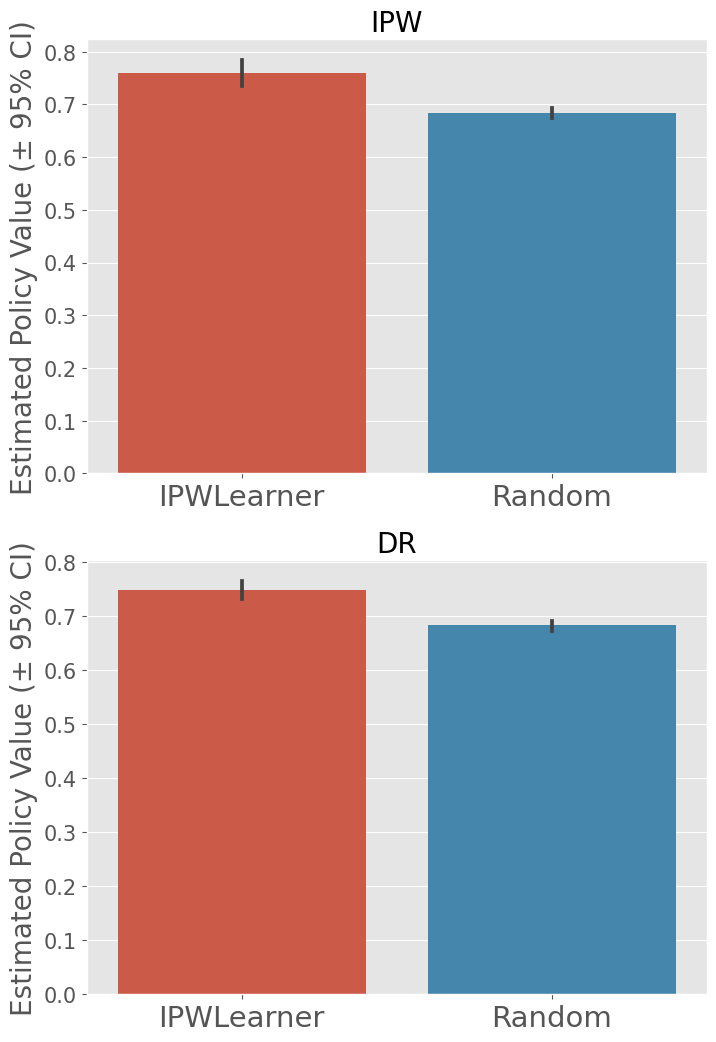

In [14]:
# IPWLearner + ロジスティック回帰の性能をIPS推定量とDR推定量で評価する
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "Random"],   # 比較する意思決定モデルの名前
    action_dist_list=[
        action_choice_by_ipw_learner,   # IPWLearnerの行動選択確率
        action_choice_by_random,   # ランダムな行動選択確率
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,   # 目的変数予測モデルによる期待報酬の推定値
    random_state=12345,
)

### 可視化

In [15]:
# IPWLearnerとrandomの真の性能を計算する
performance_of_ipw_learner = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_ipw_learner,
)
performance_of_random = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_random,
)

print("Performance of IPWLearner:", performance_of_ipw_learner)
print("Performance of Random:", performance_of_random)

Performance of IPWLearner: 0.7615802728446948
Performance of Random: 0.6909769462361114
